## LCC calculation tests (for single rail analysis)

Notebook to test the LCC calculations for the single rail analysis, i.e., either high or low rail.

Log:
- Version 2025-05-07: initial version with simple exploration of all possible maintenance strategies.
- Version 2025-05-12: reading preliminary (simulation data) tables for CM 2025 conference
- Version 2025-05-15: preliminary analysis of the LCC-optimal maintenance strategies of low and high rail separately.

## Reading input data

In [1]:
# Ensure the preprocessings module is accessible
import sys
sys.path.append('../')  # Adjust the path to the root directory containing 'preprocessings'

# Import the function to read the input data
from preprocessings.read_input_data import read_input_data

# Call the function to read the data
#file_path = '../data/raw/CM2025/BDL_111_results_JL_R1465.csv'
file_path = '../data/raw/CM2025/BDL_111_results_JL_R495.csv'
#file_path = '../data/raw/mistra_result_test_R495.csv' # example from prior project
data_df = read_input_data(file_path)

## Interpolation

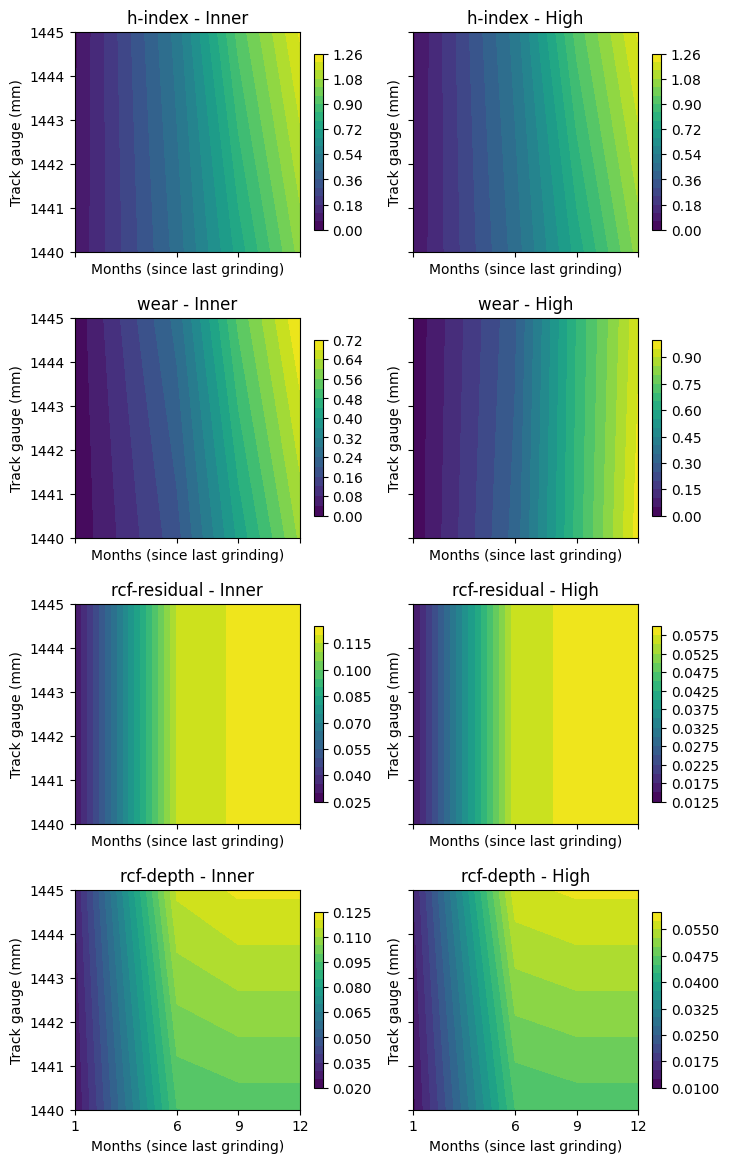

In [2]:
# interpolate the using interpolate_rail_data
from rail_analysis.interpolation import interpolate_rail_data
data_df_interpolated = interpolate_rail_data(data_df)

# plot the six figures using plot_six_figures
from rail_analysis.interpolation import plot_all_interpolated_tables
plot_all_interpolated_tables(data_df_interpolated)

## LCC calculation - high/low rail separately

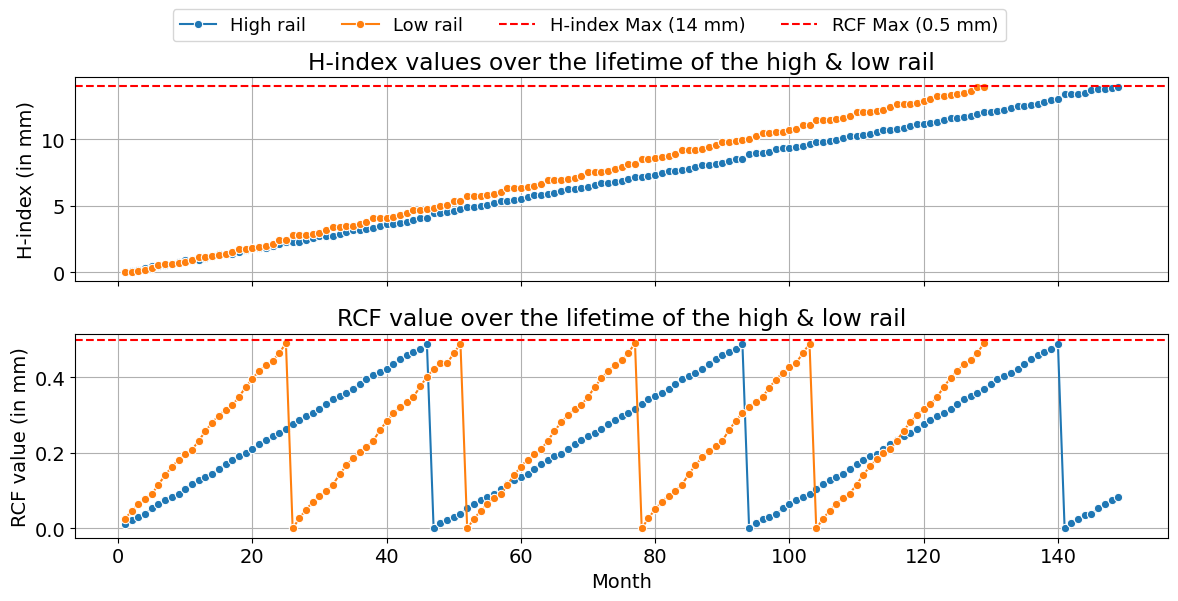

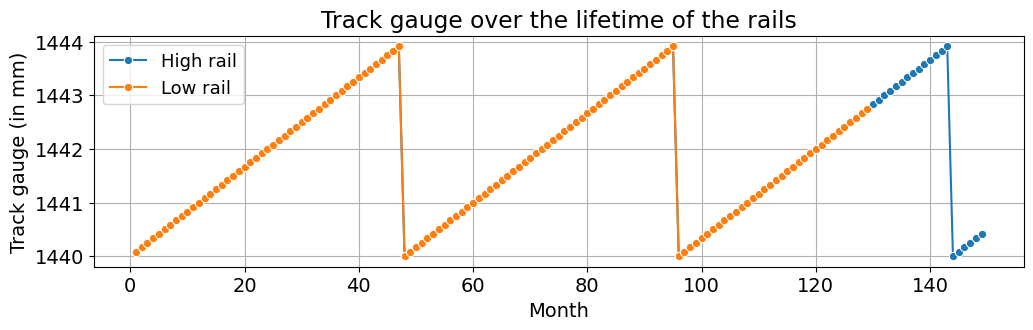

Low rail - Annuity: 543.33 SEK/m/year, Lifetime: 10.83 years
High rail - Annuity: 513.37 SEK/m/year, Lifetime: 12.50 years


In [3]:
from rail_analysis.LCC_single_rail import get_annuity_refactored, plot_historical_data_both_rails

# Example of maintenance frequencies
grinding_freq_low = 6  # months
grinding_freq_high = 5  # months
gauge_freq = 48  # months


# Calculate for low rail
maint_strategy_low = (grinding_freq_low, gauge_freq)
annuity_low, lifetime_low, history_low = get_annuity_refactored(
    data_df_interpolated,
    maint_strategy_low,
    high_or_low_rail='Inner',
    track_results=True
)


# Calculate for high rail
maint_strategy_high = (grinding_freq_high, gauge_freq)
annuity_high, lifetime_high, history_high = get_annuity_refactored(
    data_df_interpolated,
    maint_strategy_high,
    high_or_low_rail='High',
    track_results=True
)

plot_historical_data_both_rails(history_low, history_high)

print(f"Low rail - Annuity: {annuity_low:.2f} SEK/m/year, Lifetime: {lifetime_low:.2f} years")
print(f"High rail - Annuity: {annuity_high:.2f} SEK/m/year, Lifetime: {lifetime_high:.2f} years")

<Figure size 1200x600 with 0 Axes>

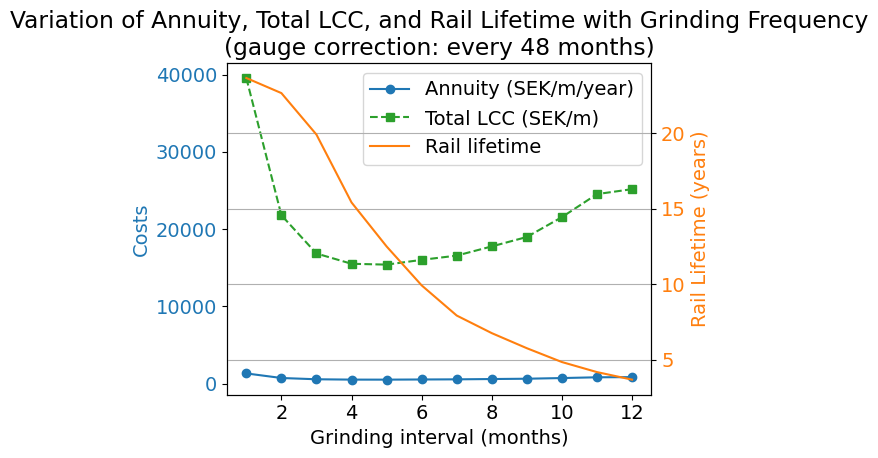

Optimal annuity of 513.37 SEK/m/year is reached at a grinding frequency of 5 months, with a rail lifetime of 12.50 years.


<Figure size 1200x600 with 0 Axes>

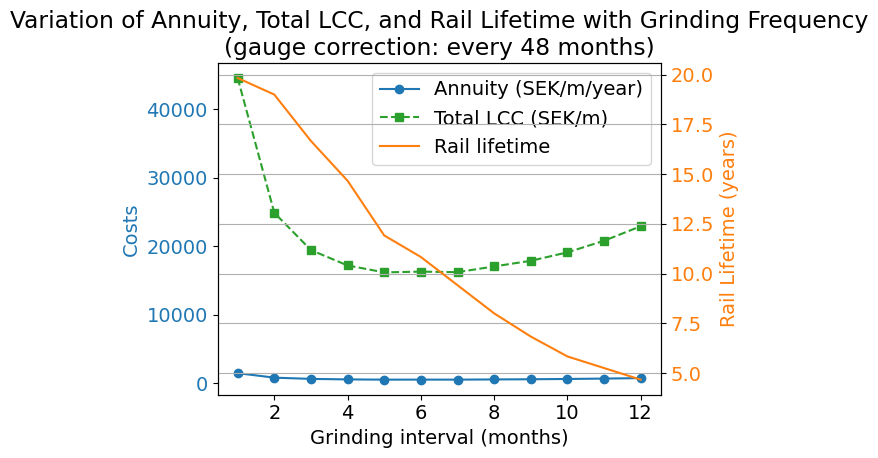

Optimal annuity of 539.71 SEK/m/year is reached at a grinding frequency of 5 months, with a rail lifetime of 11.92 years.


In [4]:
from rail_analysis.LCC_single_rail import plot_annuity_and_lifetime_with_tamping
tamping_frequency = 48  # months

plot_annuity_and_lifetime_with_tamping(tamping_frequency, data_df_interpolated, high_or_low_rail='High')
plot_annuity_and_lifetime_with_tamping(tamping_frequency, data_df_interpolated, high_or_low_rail='Inner')

## Annuity and lifetime for different grinding frequencies - high/low rail separately

First, the annuity given a specific gauge correction frequency (every 48 months = 4 years).

In [5]:
import matplotlib.pyplot as plt

# Prepare frequency range
grinding_freqs = list(range(1, 13))
annuity_lows = []
annuity_highs = []
# also plot the lifetime
lifetime_lows = []
lifetime_highs = []

for freq in grinding_freqs:
    # Use the same gauge_freq as before
    maint_strategy = (freq, gauge_freq)
    ann_low, life_low, _ = get_annuity_refactored(data_df_interpolated, maint_strategy, high_or_low_rail='Inner')
    ann_high, life_high, _ = get_annuity_refactored(data_df_interpolated, maint_strategy, high_or_low_rail='High')
    annuity_lows.append(ann_low)
    annuity_highs.append(ann_high)
    lifetime_lows.append(life_low)
    lifetime_highs.append(life_high)



Then, lifetime (given a specific gauge correction frequency (every 48 months = 4 years)).

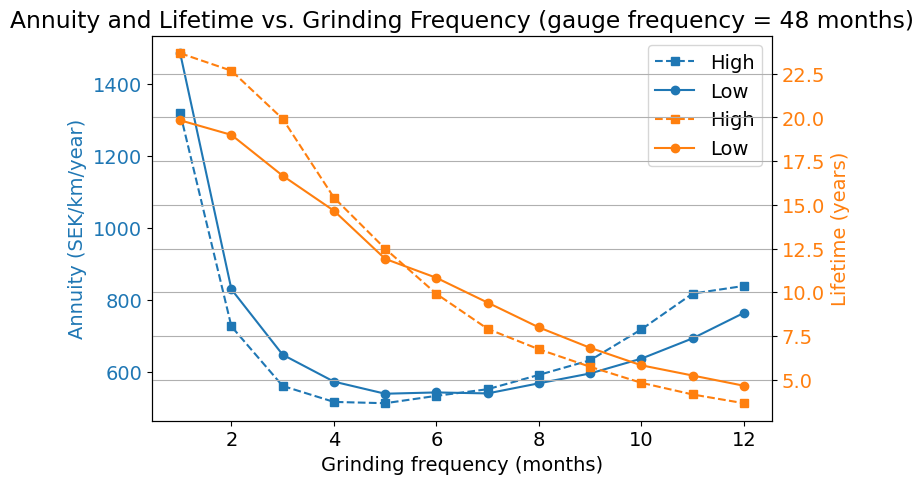

In [6]:
fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
color2 = 'tab:orange'

# Plot annuity on left y-axis
ax1.set_xlabel('Grinding frequency (months)')
ax1.set_ylabel('Annuity (SEK/km/year)', color=color1)
ax1.plot(grinding_freqs, annuity_highs, marker='s', label='High', color=color1, linestyle='--')
ax1.plot(grinding_freqs, annuity_lows, marker='o', label='Low', color=color1, linestyle='-')

ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis for lifetime
ax2 = ax1.twinx()
ax2.set_ylabel('Lifetime (years)', color=color2)
ax2.plot(grinding_freqs, lifetime_highs, marker='s', label='High', color=color2, linestyle='--')
ax2.plot(grinding_freqs, lifetime_lows, marker='o', label='Low', color=color2, linestyle='-')
ax2.tick_params(axis='y', labelcolor=color2)

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('Annuity and Lifetime vs. Grinding Frequency (gauge frequency = 48 months)')
plt.grid(True)
plt.show()

## Variation of annuity for different grinding and gauge correction frequencies

In [7]:
import numpy as np

# Define frequency ranges
grinding_range = range(1, 13)  # 1 to 12 months
gauge_range = range(12, 49, 3)  # 1 to 48 months, step 4

# Prepare result arrays
annuity_matrix_high = np.zeros((len(grinding_range), len(gauge_range)))
lifetime_matrix_high = np.zeros((len(grinding_range), len(gauge_range)))
annuity_matrix_low = np.zeros((len(grinding_range), len(gauge_range)))
lifetime_matrix_low = np.zeros((len(grinding_range), len(gauge_range)))

# Calculate annuity and lifetime for each combination for both rails
for i, grind_freq in enumerate(grinding_range):
    for j, gauge_freq in enumerate(gauge_range):
        strategy = (grind_freq, gauge_freq)
        ann_high, life_high, _ = get_annuity_refactored(data_df_interpolated, strategy, high_or_low_rail='High')
        ann_low, life_low, _ = get_annuity_refactored(data_df_interpolated, strategy, high_or_low_rail='Inner')
        annuity_matrix_high[i, j] = ann_high
        lifetime_matrix_high[i, j] = life_high
        annuity_matrix_low[i, j] = ann_low
        lifetime_matrix_low[i, j] = life_low

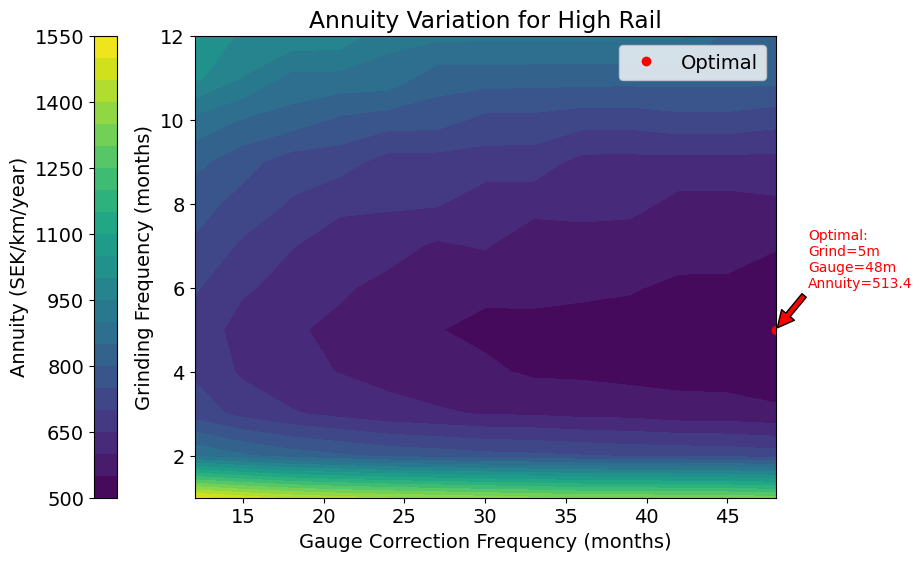

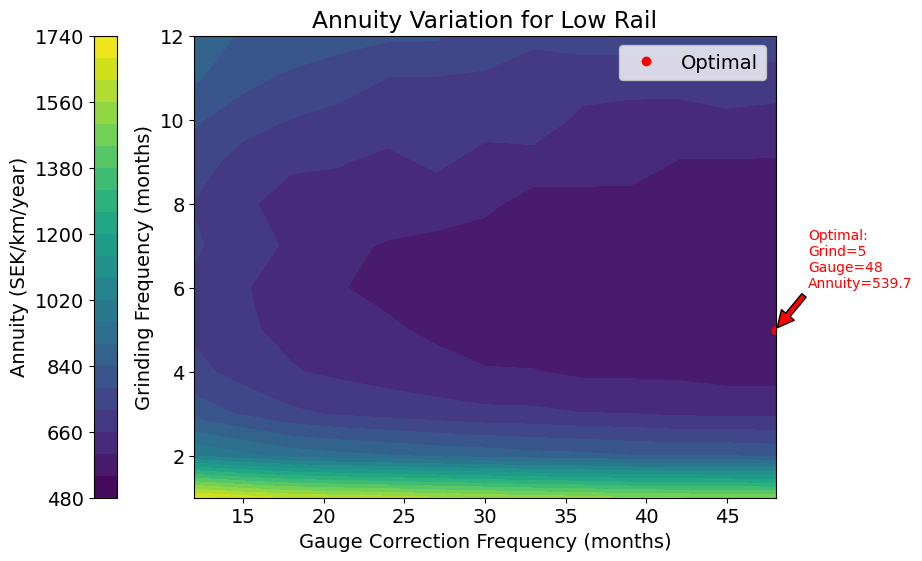

In [8]:
# Find optimal for high rail
min_index_high = np.unravel_index(np.argmin(annuity_matrix_high), annuity_matrix_high.shape)
opt_grind_high = grinding_range[min_index_high[0]]
opt_gauge_high = gauge_range[min_index_high[1]]
opt_ann_high = annuity_matrix_high[min_index_high]

# Plot for High Rail
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(gauge_range, grinding_range)
cp = plt.contourf(X, Y, annuity_matrix_high, levels=20, cmap='viridis')
plt.colorbar(cp, label='Annuity (SEK/km/year)', orientation='vertical', ax=plt.gca(), location='left')
plt.xlabel('Gauge Correction Frequency (months)')
plt.ylabel('Grinding Frequency (months)')
plt.title('Annuity Variation for High Rail')
# Mark optimal point
plt.plot(opt_gauge_high, opt_grind_high, 'ro', label='Optimal')
plt.legend()
plt.annotate(f'Optimal:\nGrind={opt_grind_high}m\nGauge={opt_gauge_high}m\nAnnuity={opt_ann_high:.1f}',
             xy=(opt_gauge_high, opt_grind_high), xytext=(opt_gauge_high+2, opt_grind_high+1),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red')
plt.show()

# Find optimal for low rail
min_index_low = np.unravel_index(np.argmin(annuity_matrix_low), annuity_matrix_low.shape)
opt_grind_low = grinding_range[min_index_low[0]]
opt_gauge_low = gauge_range[min_index_low[1]]
opt_ann_low = annuity_matrix_low[min_index_low]

# Plot for Low Rail
plt.figure(figsize=(10, 6))
cp = plt.contourf(X, Y, annuity_matrix_low, levels=20, cmap='viridis')
plt.colorbar(cp, label='Annuity (SEK/km/year)', orientation='vertical', ax=plt.gca(), location='left')
plt.xlabel('Gauge Correction Frequency (months)')
plt.ylabel('Grinding Frequency (months)')
plt.title('Annuity Variation for Low Rail')
# Mark optimal point
plt.plot(opt_gauge_low, opt_grind_low, 'ro', label='Optimal')
plt.legend()
plt.annotate(f'Optimal:\nGrind={opt_grind_low}\nGauge={opt_gauge_low}\nAnnuity={opt_ann_low:.1f}',
             xy=(opt_gauge_low, opt_grind_low), xytext=(opt_gauge_low+2, opt_grind_low+1),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red')
plt.show()

In [9]:
# Find optimal for high rail
min_index_high = np.unravel_index(np.argmin(annuity_matrix_high), annuity_matrix_high.shape)
opt_grind_high = grinding_range[min_index_high[0]]
opt_gauge_high = gauge_range[min_index_high[1]]
opt_ann_high = annuity_matrix_high[min_index_high]
opt_life_high = lifetime_matrix_high[min_index_high]

# Find optimal for low rail
min_index_low = np.unravel_index(np.argmin(annuity_matrix_low), annuity_matrix_low.shape)
opt_grind_low = grinding_range[min_index_low[0]]
opt_gauge_low = gauge_range[min_index_low[1]]
opt_ann_low = annuity_matrix_low[min_index_low]
opt_life_low = lifetime_matrix_low[min_index_low]

print(f"High rail - Optimal grinding: {opt_grind_high} months, gauge: {opt_gauge_high} months, annuity: {opt_ann_high:.2f} SEK/km/year, lifetime: {opt_life_high:.2f} years")
print(f"Low rail  - Optimal grinding: {opt_grind_low} months, gauge: {opt_gauge_low} months, annuity: {opt_ann_low:.2f} SEK/km/year, lifetime: {opt_life_low:.2f} years")

High rail - Optimal grinding: 5 months, gauge: 48 months, annuity: 513.37 SEK/km/year, lifetime: 12.50 years
Low rail  - Optimal grinding: 5 months, gauge: 48 months, annuity: 539.71 SEK/km/year, lifetime: 11.92 years
